# KMeans outlier detection model
Outlier detection model using KMeans to cluster the dataset and an upper quantile threshold to find records that are far from their cluster centers.

In [0]:
import pandas as pd
import math

import json

# Matplotlib for visualization at the end
import matplotlib.pyplot as plt

from pyspark.sql.functions import col, when, lit, udf, current_date, date_sub
from pyspark.sql.types import StructType, StructField, StringType, DoubleType

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

### Data load from DBFS store

In [0]:
# Load selected features
feature_cols_json = dbutils.fs.head("dbfs:/tmp/feature_cols.json")
feature_cols = json.loads(feature_cols_json)
feature_cols

Out[8]: ['temperature_2m', 'precipitation', 'wind_gusts_10m', 'cloud_cover']

In [0]:
# Load data from DBFS
spark.sql("REFRESH TABLE historical_weather_hourly_lisbon") # refresh in case updated
sdf = spark.table("historical_weather_hourly_lisbon")
display(sdf.limit(10))

time,temperature_2m,precipitation,wind_gusts_10m,cloud_cover,features,features_scaled
2025-03-02T12:00,11.9,0.0,35.6,100.0,"Map(vectorType -> dense, length -> 4, values -> List(11.9, 0.0, 35.6, 100.0))","Map(vectorType -> dense, length -> 4, values -> List(-1.0715630887496022, -0.2045818640908716, 0.9129135165605267, 1.1864919785095578))"
2025-03-02T13:00,12.8,0.0,33.5,97.0,"Map(vectorType -> dense, length -> 4, values -> List(12.8, 0.0, 33.5, 97.0))","Map(vectorType -> dense, length -> 4, values -> List(-0.8981816211481713, -0.2045818640908716, 0.7568701329712245, 1.1096330649379178))"
2025-03-02T14:00,13.5,0.0,29.2,91.0,"Map(vectorType -> dense, length -> 4, values -> List(13.5, 0.0, 29.2, 91.0))","Map(vectorType -> dense, length -> 4, values -> List(-0.7633293685692809, -0.2045818640908716, 0.43735272847884427, 0.9559152377946378))"
2025-03-02T15:00,13.1,0.0,31.0,92.0,"Map(vectorType -> dense, length -> 4, values -> List(13.1, 0.0, 31.0, 92.0))","Map(vectorType -> dense, length -> 4, values -> List(-0.8403877986143613, -0.2045818640908716, 0.5711042001268174, 0.9815348756518512))"
2025-03-02T16:00,12.9,0.3,32.8,95.0,"Map(vectorType -> dense, length -> 4, values -> List(12.9, 0.3, 32.8, 95.0))","Map(vectorType -> dense, length -> 4, values -> List(-0.8789170136369013, 0.6885826956378645, 0.7048556717747904, 1.0583937892234911))"
2025-03-02T17:00,12.4,0.4,33.1,93.0,"Map(vectorType -> dense, length -> 4, values -> List(12.4, 0.4, 33.1, 93.0))","Map(vectorType -> dense, length -> 4, values -> List(-0.9752400511932517, 0.9863042155474432, 0.7271475837161195, 1.0071545135090645))"
2025-03-02T18:00,11.8,0.0,33.1,88.0,"Map(vectorType -> dense, length -> 4, values -> List(11.8, 0.0, 33.1, 88.0))","Map(vectorType -> dense, length -> 4, values -> List(-1.0908276962608723, -0.2045818640908716, 0.7271475837161195, 0.879056324222998))"
2025-03-02T19:00,11.3,0.0,31.3,86.0,"Map(vectorType -> dense, length -> 4, values -> List(11.3, 0.0, 31.3, 86.0))","Map(vectorType -> dense, length -> 4, values -> List(-1.1871507338172227, -0.2045818640908716, 0.5933961120681464, 0.8278170485085713))"
2025-03-02T20:00,11.0,0.0,29.5,84.0,"Map(vectorType -> dense, length -> 4, values -> List(11.0, 0.0, 29.5, 84.0))","Map(vectorType -> dense, length -> 4, values -> List(-1.244944556351033, -0.2045818640908716, 0.45964464042017317, 0.7765777727941446))"
2025-03-02T21:00,10.6,0.0,28.8,73.0,"Map(vectorType -> dense, length -> 4, values -> List(10.6, 0.0, 28.8, 73.0))","Map(vectorType -> dense, length -> 4, values -> List(-1.3220029863961136, -0.2045818640908716, 0.40763017922373923, 0.494761756364798))"


### Utility functions

In [0]:
def train_kmeans_model(df, k, features_col):
    # Trains a k-means model.
    # Inspired by https://spark.apache.org/docs/latest/ml-clustering.html
    kmeans = KMeans().setK(k).setSeed(1)
    kmeans.setFeaturesCol(features_col) # Set custom feature vector col
    model = kmeans.fit(df)
    return model

def compute_distance(point, cluster_id):
    # Function to compute distance between a point and its cluster centroid - "centers" needs to be callable
    center = centers[cluster_id]
    return float(math.sqrt(sum((p - c)**2 for p, c in zip(point, center))))

### Assembly of dataset and preprocessing
Assembly and Scaling were moved to Data Notebook - now only seeing if the data has the correct assembled column

In [0]:
# observe: we have a "features" and "features_scaled" column
sdf

Out[11]: DataFrame[time: string, temperature_2m: double, precipitation: double, wind_gusts_10m: double, cloud_cover: double, features: vector, features_scaled: vector]

### K-Means Cluster Count - Discovery/Tuning
Initial K-Means Tuning to discover the best amount of K for our data.

In [0]:
# Loop to test different k values and evaluate the models
for k in range(2, 10):
    # Train k means with specific k
    model = train_kmeans_model(sdf, k, "features_scaled")

    # Make predictions
    predictions = model.transform(sdf)

    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()

    silhouette = evaluator.evaluate(predictions)
    print("Silhouette score:" + str(silhouette) + " for k = " + str(k))

    # Shows the result.
    centers = model.clusterCenters()
    print("Cluster Centers (scaled): ")
    for center in centers:
        print(center)

    print("---")

Silhouette score:0.7524712758599418 for k = 2
Cluster Centers (scaled): 
[-0.22657035  0.16964875  0.06121659  0.81426502]
[ 0.27272567 -0.20420841 -0.07368721 -0.98014138]
---
Silhouette score:0.4481657872136099 for k = 3
Cluster Centers (scaled): 
[ 1.23568423 -0.19698839  0.70902155 -0.7039488 ]
[-0.57945931 -0.20399371 -0.66629215 -0.87906222]
[-0.26374619  0.22171257  0.05102722  0.88328433]
---
Silhouette score:0.18502152032756278 for k = 4
Cluster Centers (scaled): 
[ 1.16705533 -0.18530493  0.79930228 -0.5816547 ]
[-0.29262464 -0.08508768 -0.16790867  0.82941343]
[-0.39490257  4.4826236   1.46667292  1.14454334]
[-0.57157064 -0.20419738 -0.6510805  -0.99296389]
---
Silhouette score:0.19385620767688347 for k = 5
Cluster Centers (scaled): 
[-0.44636939 -0.13984981 -0.73828352  0.80166408]
[-0.60335793 -0.20416682 -0.61626123 -1.04245223]
[0.12188989 0.00532158 0.9229587  0.64517202]
[ 1.47154046 -0.20438829  0.5420049  -1.0127657 ]
[-0.39739143  5.13640373  1.38947658  1.15002868

### Optimal Model Training and Saving
Saving model to dbfs for it to be used in streaming notebook


In [0]:
# save best model with k=4 for streaming usage
model = train_kmeans_model(sdf, 2, "features_scaled")
model.write().overwrite().save("/dbfs/tmp/kmeans_model")

### Application on training data and computation of distance threshold
Distance threshold is max distance to a datapoints' cluster center before it's considered an outlier.

In [0]:
# Apply model on training data
predicted_sdf = model.transform(sdf)

# Cluster centers
centers = model.clusterCenters()

# UDF (user defined function) for distance computation
distance_udf = udf(compute_distance, DoubleType()) # Function defined above (Utility Functions) - with double as return value for distance
# Apply distance UDF to all points
scored_sdf = predicted_sdf.withColumn(
    "distance_cluster_center", 
    distance_udf(col("features_scaled"), col("prediction"))
)

# Compute distance threshold for anomalies
distance_threshold = scored_sdf.approxQuantile("distance_cluster_center", [0.95], 0.01)[0] # 0.95 percentile as threshold

# Save threshold as a JSON file
dbutils.fs.put("dbfs:/tmp/kmeans_distance_threshold.json", json.dumps(distance_threshold), overwrite=True)

Wrote 16 bytes.
Out[13]: True

## Application on Historical (training) data and Visualization

### Outlier detection on training data

In [0]:
# Flag highest distances as anomalies
scored_sdf = scored_sdf.withColumn(
    "is_anomaly",
    when(col("distance_cluster_center") > distance_threshold, 1).otherwise(0)
)

scored_sdf.select("features", "features_scaled", "prediction", "distance_cluster_center", "is_anomaly").show(truncate=False) # Check

scored_sdf

+---------------------+----------------------------------------------------------------------------------+----------+-----------------------+----------+
|features             |features_scaled                                                                   |prediction|distance_cluster_center|is_anomaly|
+---------------------+----------------------------------------------------------------------------------+----------+-----------------------+----------+
|[11.9,0.0,35.6,100.0]|[-1.0715630887496022,-0.2045818640908716,0.9129135165605267,1.1864919785095578]   |0         |1.3107256947302404     |0         |
|[12.8,0.0,33.5,97.0] |[-0.8981816211481713,-0.2045818640908716,0.7568701329712245,1.1096330649379178]   |0         |1.0780938677444958     |0         |
|[13.5,0.0,29.2,91.0] |[-0.7633293685692809,-0.2045818640908716,0.43735272847884427,0.9559152377946378]  |0         |0.7679205543133978     |0         |
|[13.1,0.0,31.0,92.0] |[-0.8403877986143613,-0.2045818640908716,0.5711042001268174

### Large year-round visualization
Visualization to check the outlier detection for the historical year.

In [0]:
# Filter dataframe for last 45 days
previous_date = date_sub(current_date(), 45)
filtered_sdf = scored_sdf.filter(col("time") >= previous_date)

# Select needed columns
plot_df = filtered_sdf.select(
    "time",
    "temperature_2m",
    "wind_gusts_10m",
    "precipitation",
    "cloud_cover",
    "distance_cluster_center",
    "is_anomaly"
).orderBy("time").toPandas()

# Extract first and last time points
first_time = plot_df["time"].iloc[0]
last_time = plot_df["time"].iloc[-1]

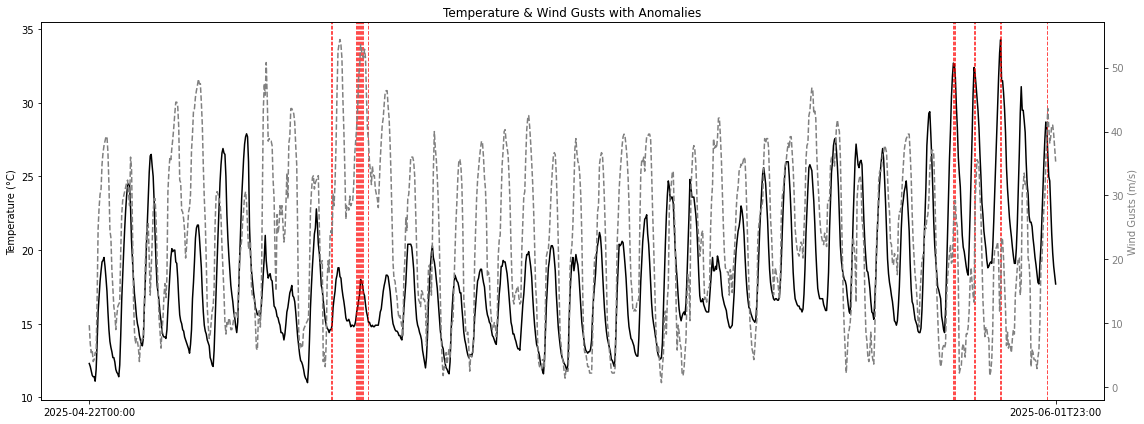

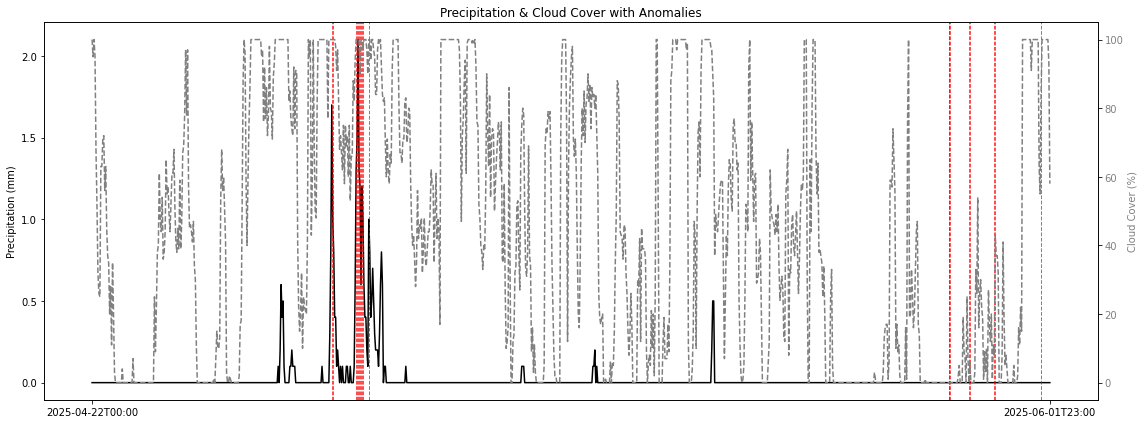

In [0]:
### Temperature & Wind Gusts ###
fig, ax1 = plt.subplots(figsize=(16, 6))

ax1.plot(plot_df["time"], plot_df["temperature_2m"], color="black", label="Temperature (°C)")
ax1.set_ylabel("Temperature (°C)", color="black")
ax1.tick_params(axis='y', labelcolor="black")
ax1.set_xticks([first_time, last_time])
ax1.set_xticklabels([first_time, last_time])

for anomaly_time in plot_df.loc[plot_df["is_anomaly"] == 1, "time"]:
    ax1.axvline(x=anomaly_time, color="red", linestyle="--", linewidth=1, alpha=0.7)

ax2 = ax1.twinx()
ax2.plot(plot_df["time"], plot_df["wind_gusts_10m"], color="gray", linestyle='--', label="Wind Gusts (m/s)")
ax2.set_ylabel("Wind Gusts (m/s)", color="gray")
ax2.tick_params(axis='y', labelcolor="gray")
ax2.get_xaxis().set_visible(False)  # Remove duplicate x labels

plt.title("Temperature & Wind Gusts with Anomalies")
fig.tight_layout()
plt.show()

### Precipitation & Cloud Cover ###
fig, ax3 = plt.subplots(figsize=(16, 6))

ax3.plot(plot_df["time"], plot_df["precipitation"], color="black", label="Precipitation (mm)")
ax3.set_ylabel("Precipitation (mm)", color="black")
ax3.tick_params(axis='y', labelcolor="black")
ax3.set_xticks([first_time, last_time])
ax3.set_xticklabels([first_time, last_time])

for anomaly_time in plot_df.loc[plot_df["is_anomaly"] == 1, "time"]:
    ax3.axvline(x=anomaly_time, color="red", linestyle="--", linewidth=1, alpha=0.7)

ax4 = ax3.twinx()
ax4.plot(plot_df["time"], plot_df["cloud_cover"], color="gray", linestyle='--', label="Cloud Cover (%)")
ax4.set_ylabel("Cloud Cover (%)", color="gray")
ax4.tick_params(axis='y', labelcolor="gray")
ax4.get_xaxis().set_visible(False)

plt.title("Precipitation & Cloud Cover with Anomalies")
fig.tight_layout()
plt.show()
